In [1]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---


# Generative adversarial networks 

Generative adversarial networks (GANs) emerge as the virtuosos of artificial creativity, painting canvases with pixels rather than pigments. At their genesis, GANs were forged with a singular mission: to breathe life into the digital realm, conjuring new data from the ethereal depths of probability distributions. Their pioneering design was a symphony of innovation, orchestrating a duel between two neural networks in a ballet of creation and critique.

Picture this: on one side of the stage stands the Generator, a prodigious apprentice armed with brushes of binary. Its purpose, its raison d'être, is to craft masterpieces ex nihilo, stitching together pixels with mathematical finesse. With each iteration, it tiptoes closer to perfection, learning the intricate tapestry of the training set distribution like a virtuoso studying the score.



Opposing it, the Discerner awaits—the arbiter of authenticity, the gatekeeper of verisimilitude. Trained to discern the genuine from the counterfeit, it scrutinizes each creation with a discerning eye, sniffing out flaws and imperfections like a seasoned art critic.

The dance begins. With each pass, the Generator's strokes grow bolder, its compositions more intricate, as it strives to outwit its adversary. Meanwhile, the Discerner stands vigilant, its discriminating gaze sharpened by every encounter. Back and forth they go, locked in an eternal tango of creation and critique.

And then, a breakthrough. In a moment of revelation, the Generator unveils a masterpiece—a synthesis of pixels so sublime, so lifelike, that even the Discerner is momentarily deceived. In that fleeting instant, the boundaries of possibility expand, as the digital canvas is imbued with the spark of innovation.

Such is the essence of GANs—a testament to the power of adversarial collaboration, where artistry and algorithm converge to redefine the boundaries of creativity. From images to text, from music to medicine, their domain knows no bounds, as they continue to shape the future of artificial intelligence, one pixel at a time.

GAN is proposed in 2005, the paper is Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio. "Generative Adversarial Networks", arxiv:1406.2661.

## Code

In [3]:
import tensorflow as tf
import requests
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Function of displaying a grid of images

In [4]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

### Functions of pre-processing and post-processing images

In [5]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count


### Download a file from a URL using the requests library

In [6]:
url = 'https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/Gan/gan-checks-tf.npz'
response = requests.get(url)
with open('gan-checks-tf.npz', 'wb') as f:
    f.write(response.content)

# Now you can use np.load on the downloaded file
answers = np.load('gan-checks-tf.npz')

NOISE_DIM = 96

### Load Data

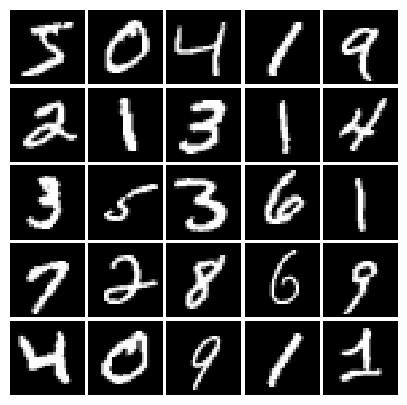

In [7]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 
mnist = MNIST(batch_size=25) 
show_images(mnist.X[:25])

### Compute the leaky ReLU activation function

In [8]:
def leaky_relu(x, alpha=0.01):
    x = tf.nn.leaky_relu(x,alpha)
    return x
    pass

### Generate random uniform noise from -1 to 1

In [9]:
def sample_noise(batch_size, dim):
    noise = tf.random.uniform([batch_size,dim],minval = -1,maxval = 1)
    return noise
    pass

### Compute discriminator score for a batch of input images

In [10]:
def discriminator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(784),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
    ])
    return model

In [12]:
warnings.filterwarnings("ignore")
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


### Compute generator score for a batch of input images

In [13]:
def generator(noise_dim=NOISE_DIM):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(noise_dim),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784,activation = tf.nn.tanh)
    ])
    return model

In [14]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


### Compute the discriminator loss

In [15]:
def discriminator_loss(logits_real, logits_fake):

    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 6.02597e-17


### Compute the generator loss

In [16]:
def generator_loss(logits_fake):
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


### Create solvers for GAN training

In [17]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = None
    G_solver = None
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass
    return D_solver, G_solver

### Train a GAN for a certain number of epochs

In [23]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=1000, print_every=20, batch_size=16, num_epochs=3, noise_size=96):
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:30])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()


Epoch: 0, Iter: 0, D: 1.14, G:0.6946


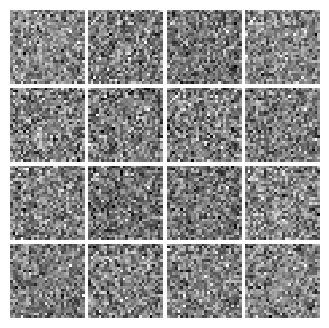

Epoch: 0, Iter: 1000, D: 0.7591, G:2.441


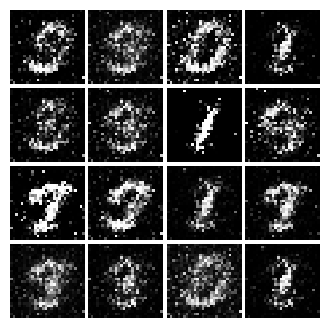

Epoch: 0, Iter: 2000, D: 0.9709, G:0.9196


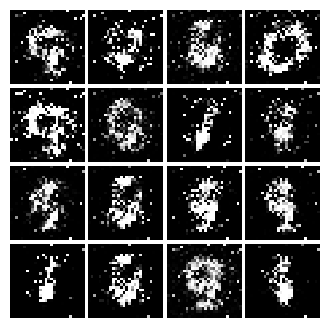

Epoch: 0, Iter: 3000, D: 1.2, G:2.018


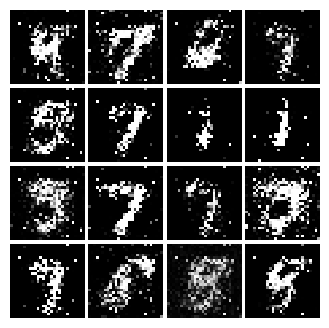

Epoch: 1, Iter: 4000, D: 1.199, G:1.177


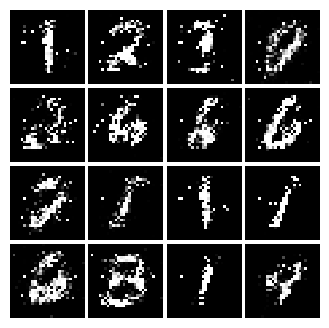

Epoch: 1, Iter: 5000, D: 1.263, G:1.492


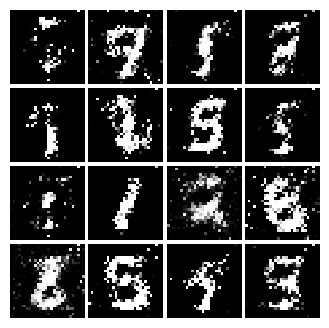

Epoch: 1, Iter: 6000, D: 1.287, G:0.8328


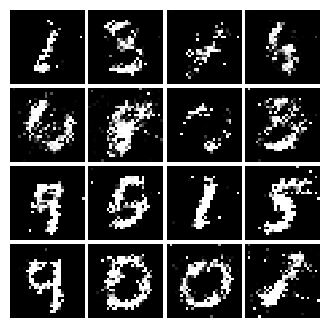

Epoch: 1, Iter: 7000, D: 1.295, G:1.124


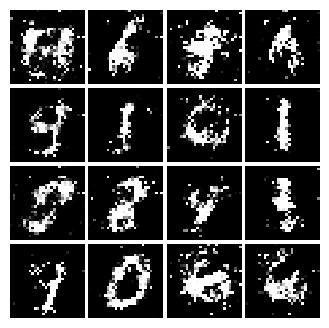

Epoch: 2, Iter: 8000, D: 1.302, G:1.125


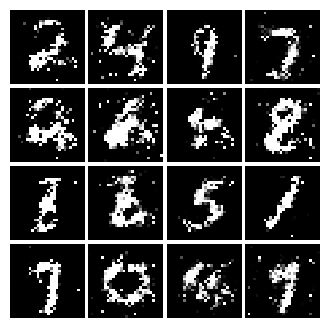

Epoch: 2, Iter: 9000, D: 1.118, G:0.6758


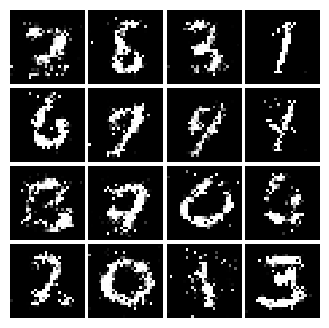

Epoch: 2, Iter: 10000, D: 1.173, G:0.7965


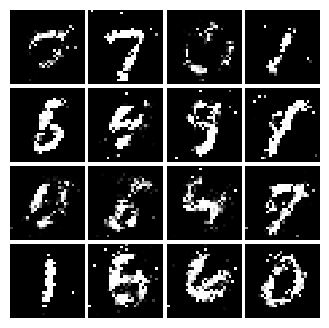

Epoch: 2, Iter: 11000, D: 1.351, G:0.9481


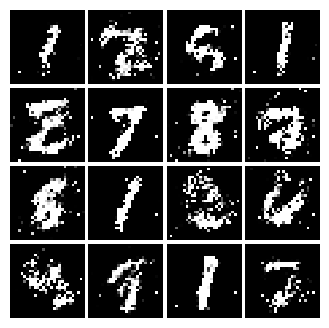

Final images


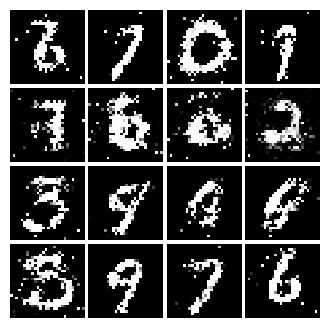

In [24]:
warnings.filterwarnings("ignore")
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

## Your turn! 🚀

Implement TODO part of the code in this notebook.

<!-- Assignment - [Art by gan](../assignments/deep-learning/gan/art-by-gan.ipynb) -->

## Acknowledgments

Thanks to [Sebastian Raschka](https://github.com/rasbt) for creating the open-source project [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20) and [Diego Gomez](https://github.com/diegoalejogm) for creating the open-source project [gans](https://github.com/diegoalejogm/gans). They inspire the majority of the content in this chapter.
